# Lab Six: Wide and Deep Network Architectures

#### Saahil Deshpande, Jeremy Holcombe, Ata Khiabani, Daniel Perez

## Business Understanding

Recommendation engines are employed by the most successful digital companies. Netflix recommends movies and shows to its users based on their viewing history; Amazon recommends products based on its users' purchase and search history; Spotify recommends new music and artists. The applications for recommendation engines, or recommender systems as they are often called, are plentiful across numerous industries.

In this lab, we will analyze the hotel search history for users of Expedia.com and build a wide and deep network to predict the type of hotel that may be of interest to a user searching on the platform.

The full data set consists of tens of millions of user events on Expedia.com from 2013 and 2014. The user events represent either a booking directly on the platform or simply a click on a candidate hotel, with the latter occurring more frequently. The data also contains a dependence structure through unique user identities that can be exploited.

The class variable for this data set represents _hotel clusters_ that Expedia has created to group hotels with similar attributes (e.g., historical pricing, customer star ratings, geographical locations relative to city center) for the purposes of recommendations. In the full data set, there are 100 such clusters. Since we will be serving up multiple recommendations to users rather than just a single hotel type, we will measure the model's performance on how well it selects an accurate hotel cluster among its top five results.

The most compelling use case for this classifier would be to order search results based on the user's query. For instance, if a user is searching for a hotel in another country for an extended period of time, that user may be more likely to book a hotel that is oriented towards leisure travel rather than business travel. Conversely, if a query spans four days in the middle of the week, results highlighting business-oriented hotels may be more likely to end in a booking than leisure-oriented hotels. Accurate predictions would likely result in a higher booking rate, and perhaps happier customers.

Customer behavior is generally difficult to model. Furthermore, customers tend to have more specific desires for potential hotels than the metadata from search queries are able to capture. For this reason, we anticipate that the features available in the data set will not cover many of the latent factors that lead a customer to book a hotel. Thus, we do not expect a particularly high accuracy. Rather, we hope that our classifier will be able to improve upon the average precision from a benchmark heuristics-based model that simply recommends the most relevant hotels for each destination. In this case, a misclassification is a relatively low-stakes outcome, as most users are accustomed to scrolling through results and will not likely leave the website if the top result does not exactly meet their needs.

An automated approach to recommending hotels is likely to be the only solution if such recommendations are desired. With tens of millions of individuals searching for hotels on Expedia.com annually, company staff would be incapable of creating manually curated recommendations for the vast number of combinations of search parameters. Other approaches for ordering search results may turn out to produce higher booking rates, such as simply ordering by distance from the specified destination, by price, or by user rating. These differences in performance could be discovered through careful experimentation, such as with A/B testing.

## Data Preparation

### Loading the Data

Data Source: https://www.kaggle.com/c/expedia-hotel-recommendations/data

In [1]:
import numpy as np
import pandas as pd

import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

The total data set takes up ~4 GB on the hard drive, so we probably do not want to read it all into memory at once. Let's first take a look at the features available in the dataset to get an idea of how we can reduce the amount of data we read in.

In [2]:
# Read in the first 1,000 rows to inspect the features
pd.read_csv('data/train.csv', nrows=1000).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
date_time                    1000 non-null object
site_name                    1000 non-null int64
posa_continent               1000 non-null int64
user_location_country        1000 non-null int64
user_location_region         1000 non-null int64
user_location_city           1000 non-null int64
orig_destination_distance    268 non-null float64
user_id                      1000 non-null int64
is_mobile                    1000 non-null int64
is_package                   1000 non-null int64
channel                      1000 non-null int64
srch_ci                      1000 non-null object
srch_co                      1000 non-null object
srch_adults_cnt              1000 non-null int64
srch_children_cnt            1000 non-null int64
srch_rm_cnt                  1000 non-null int64
srch_destination_id          1000 non-null int64
srch_destination_type_id     1000 non-null int64
is_booki

We need to think about how we might classify searches as ending in a booking for one of 100 different hotel clusters. We could use the information collected as part of the search, such as the search parameters specified (e.g., check-in, check-out, number of rooms, hotel market, country, continent), as well as other metadata collected based on the search (e.g., whether the search takes place on a mobile device, whether it is part of a travel package, distance of destination from current location). Finally, user information, such as how many clicks from a particular user ended in a booking, will be particularly useful here, as it provides information about which hotel clusters were clicked on by the user, but did _NOT_ ultimately result in a booking. This information will help us build a wide linear network that memorizes feature interactions.

In [3]:
%%time

# Read in data: specifying the data types cuts memory usage in half
df = pd.read_csv('data/train.csv',
                   usecols=['date_time', 'site_name', 'posa_continent', 'user_location_country', 'user_location_region', 
                            'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 
                            'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 
                            'srch_destination_id', 'srch_destination_type_id', 'cnt', 'hotel_continent', 
                            'hotel_country', 'hotel_market', 'is_booking', 'hotel_cluster'],
                   dtype={'date_time': 'str', 'site_name': np.int8, 'posa_continent': np.int8,
                          'user_location_country': np.int16, 'user_location_region': np.int32,
                          'user_location_city': np.int32, 'orig_destination_distance': np.float32,
                          'user_id': np.int32, 'is_mobile': np.int8, 'is_package': np.int8, 
                          'channel': np.int64, 'srch_ci': 'str', 'srch_co': 'str', 
                          'srch_adults_cnt': np.int8, 'srch_children_cnt': np.int8, 'srch_rm_cnt': np.int8,
                          'srch_destination_id': np.int32, 'srch_destination_type_id': np.int8,
                          'cnt': np.int16, 'hotel_continent': np.int8, 'hotel_country': np.int16, 
                          'hotel_market': np.int16, 'is_booking': np.int8, 'hotel_cluster': np.int8},
                   parse_dates=['date_time', 'srch_ci', 'srch_co'])

CPU times: user 2min 27s, sys: 13.8 s, total: 2min 41s
Wall time: 2min 46s


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37670293 entries, 0 to 37670292
Data columns (total 24 columns):
date_time                    datetime64[ns]
site_name                    int8
posa_continent               int8
user_location_country        int16
user_location_region         int32
user_location_city           int32
orig_destination_distance    float32
user_id                      int32
is_mobile                    int8
is_package                   int8
channel                      int64
srch_ci                      object
srch_co                      object
srch_adults_cnt              int8
srch_children_cnt            int8
srch_rm_cnt                  int8
srch_destination_id          int32
srch_destination_type_id     int8
is_booking                   int8
cnt                          int16
hotel_continent              int8
hotel_country                int16
hotel_market                 int16
hotel_cluster                int8
dtypes: datetime64[ns](1), float32(1), int1

### Creating a Sample

In the end, we are trying to make predictions for users, including using their previous booking history, so we will want to retain the dependence structure of events for specific users. This means that as we downsample our data set to tune our hyperparameters or experiment with different learning algorithms or architectures, we will want to randomly sample _users_, not just _observations_.

To reduce computation time, we will downsample our data set to the top 1,000 users. This will allow us to prioritize the recommendations that we provide to our best users to ensure that we retain their business. Future iterations of the model can incorporate additional data and broaden the scope of users that it targets.

In [75]:
USER_SAMPLE_SIZE = 1000

# Randomly sample user IDs
user_sample = df.user_id.value_counts().head(USER_SAMPLE_SIZE).index
df_sample = df[df.user_id.isin(user_sample)]

In [76]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396468 entries, 5376 to 37644197
Data columns (total 24 columns):
date_time                    396468 non-null datetime64[ns]
site_name                    396468 non-null int8
posa_continent               396468 non-null int8
user_location_country        396468 non-null int16
user_location_region         396468 non-null int32
user_location_city           396468 non-null int32
orig_destination_distance    209515 non-null float32
user_id                      396468 non-null int32
is_mobile                    396468 non-null int8
is_package                   396468 non-null int8
channel                      396468 non-null int64
srch_ci                      396468 non-null object
srch_co                      396468 non-null object
srch_adults_cnt              396468 non-null int8
srch_children_cnt            396468 non-null int8
srch_rm_cnt                  396468 non-null int8
srch_destination_id          396468 non-null int32
srch_destin

### Data Cleaning

In [77]:
df_sample.shape

(396468, 24)

In [78]:
df_sample.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
5376,2013-01-07 11:55:05,2,3,66,258,4687,836.274597,33803,0,1,...,0,1,12228,6,0,3,2,50,411,3
5377,2013-01-12 07:05:27,2,3,66,258,4687,834.727295,33803,0,0,...,0,1,12230,6,0,1,2,50,411,83
5378,2013-01-14 16:21:36,2,3,66,258,4687,1758.389893,33803,1,0,...,0,1,12216,6,0,1,2,50,365,41
5379,2013-01-19 18:30:56,2,3,66,258,4687,1762.165039,33803,1,0,...,0,1,12216,6,0,1,2,50,365,97
5380,2013-01-19 18:32:38,2,3,66,258,4687,1758.385742,33803,1,0,...,0,1,12216,6,0,5,2,50,365,69


#### Missing Values
Before we perform any kind of feature engineering, we should check for missing values.

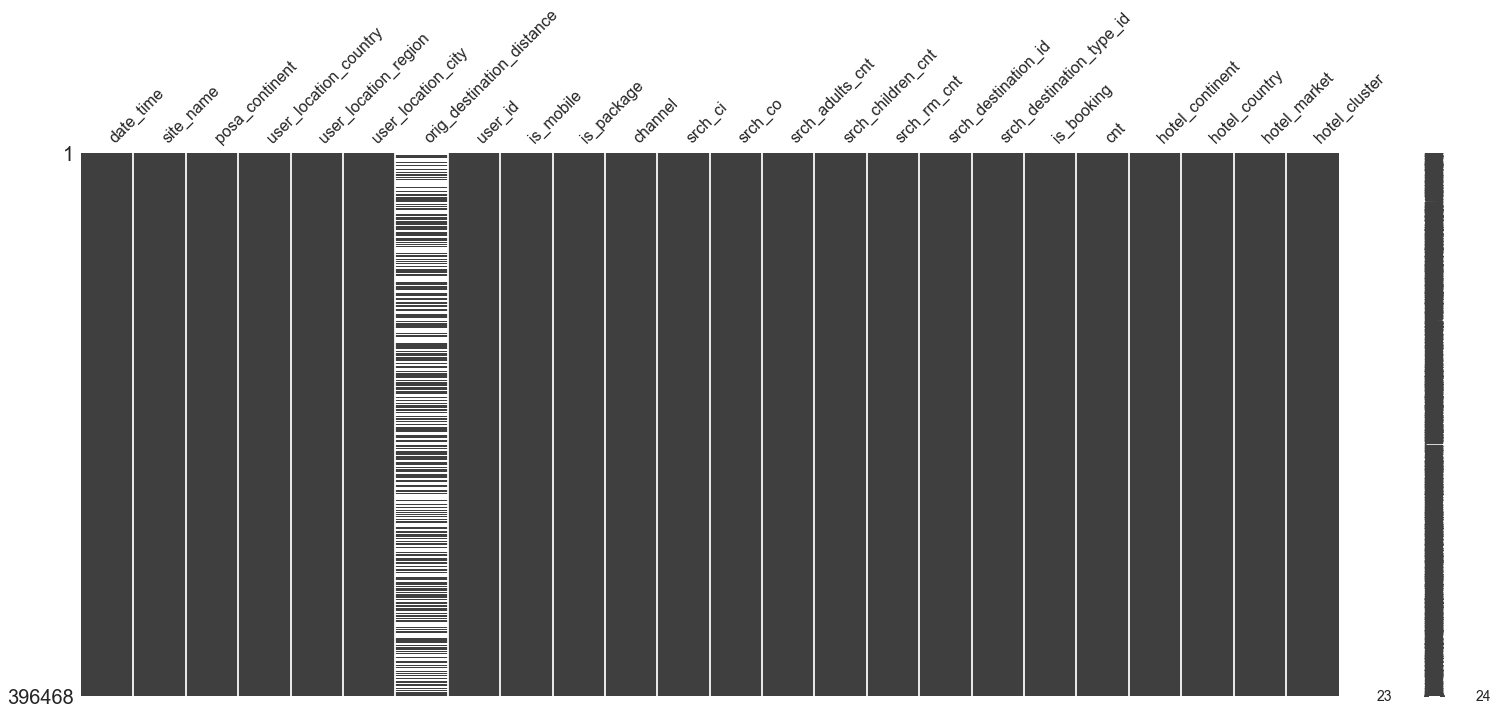

In [79]:
msno.matrix(df_sample)

It appears that we have one variable with many missing values: `orig_destination_distance`. Let's go ahead and remove this variable since so many of the values are missing. We can revisit this later with different imputation schemes as we try to improve our classifier.

In [80]:
df_sample.drop('orig_destination_distance', axis=1, inplace=True)

Let's visualize the matrix one more time to ensure we have accounted for all of the missing values.

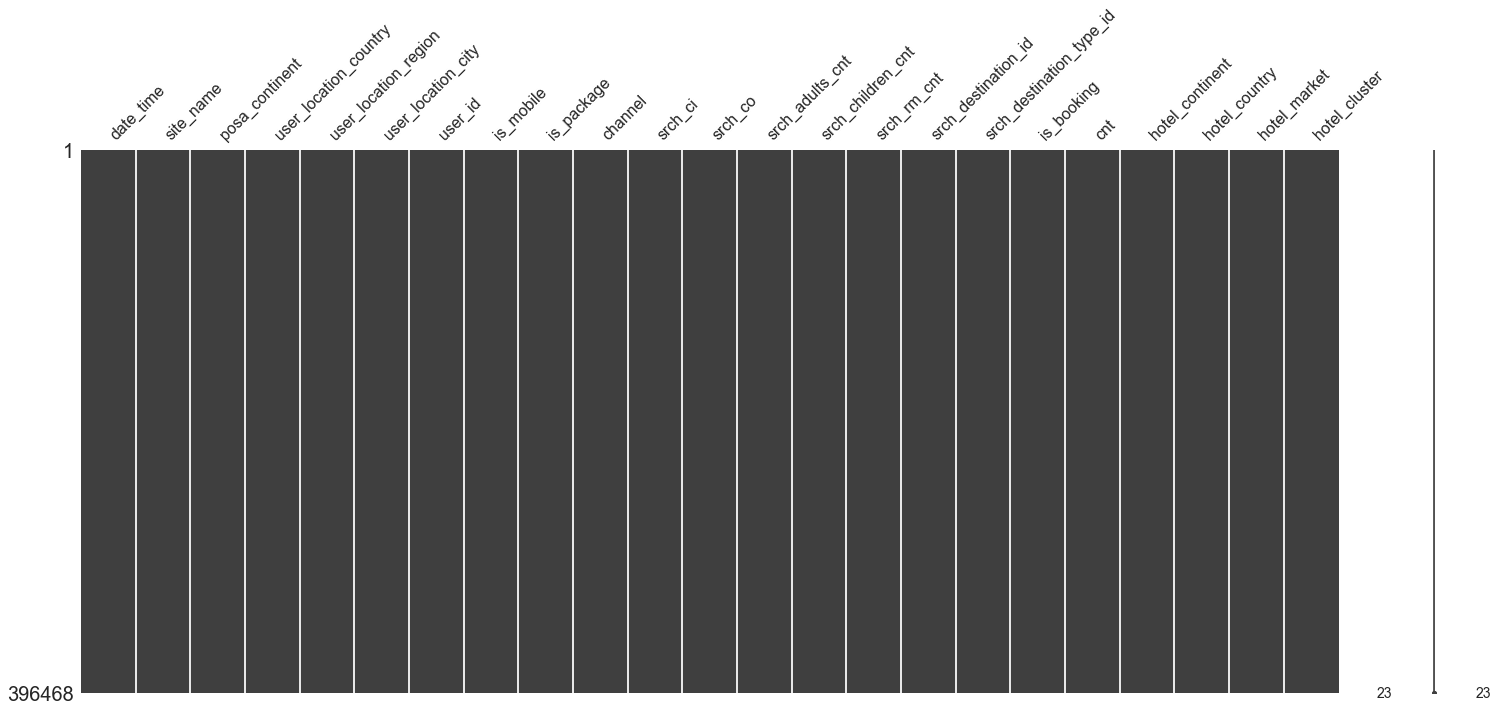

In [81]:
msno.matrix(df_sample)

#### Dimensionality Reduction for Categorical Variables

Having categories with many levels is not inherently an issue. However, a problem arises when some levels of a category have insufficient data from which to construct an estimator. For instance, if a country in which a hotel is located has only been visited one time, then we will not have enough information to make an accurate prediction for that country. There are different ways to account for this problem, but for this data set, we will collapse all levels of a category that have fewer instances than some threshold into the most common level for that category.

First, let's define the features we will be using.

In [82]:
# Specify headers for categorical variables
categorical_variables = ['site_name', 'posa_continent', 'user_location_country', 'user_location_region', 
                         'user_location_city', 'is_mobile', 'is_package', 'channel', 
                         'srch_destination_type_id', 'is_booking', 'hotel_continent', 'hotel_country', 
                         'hotel_market']

# Specify headers for numeric variables
numeric_variables = ['srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'cnt']

Next, we will visualize how many unique values exist per categorical variable. 

In [83]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

pylab.rcParams['figure.figsize'] = 16, 16

def plot_category_freq_distribution(df, categories):
    fig=plt.figure()
    for i, category in enumerate(categories):
        ax=fig.add_subplot(3,4,i+1)
        df[category].hist(ax=ax)
        ax.set_title(category+" unique count distribution")
        ax.grid('off')       
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

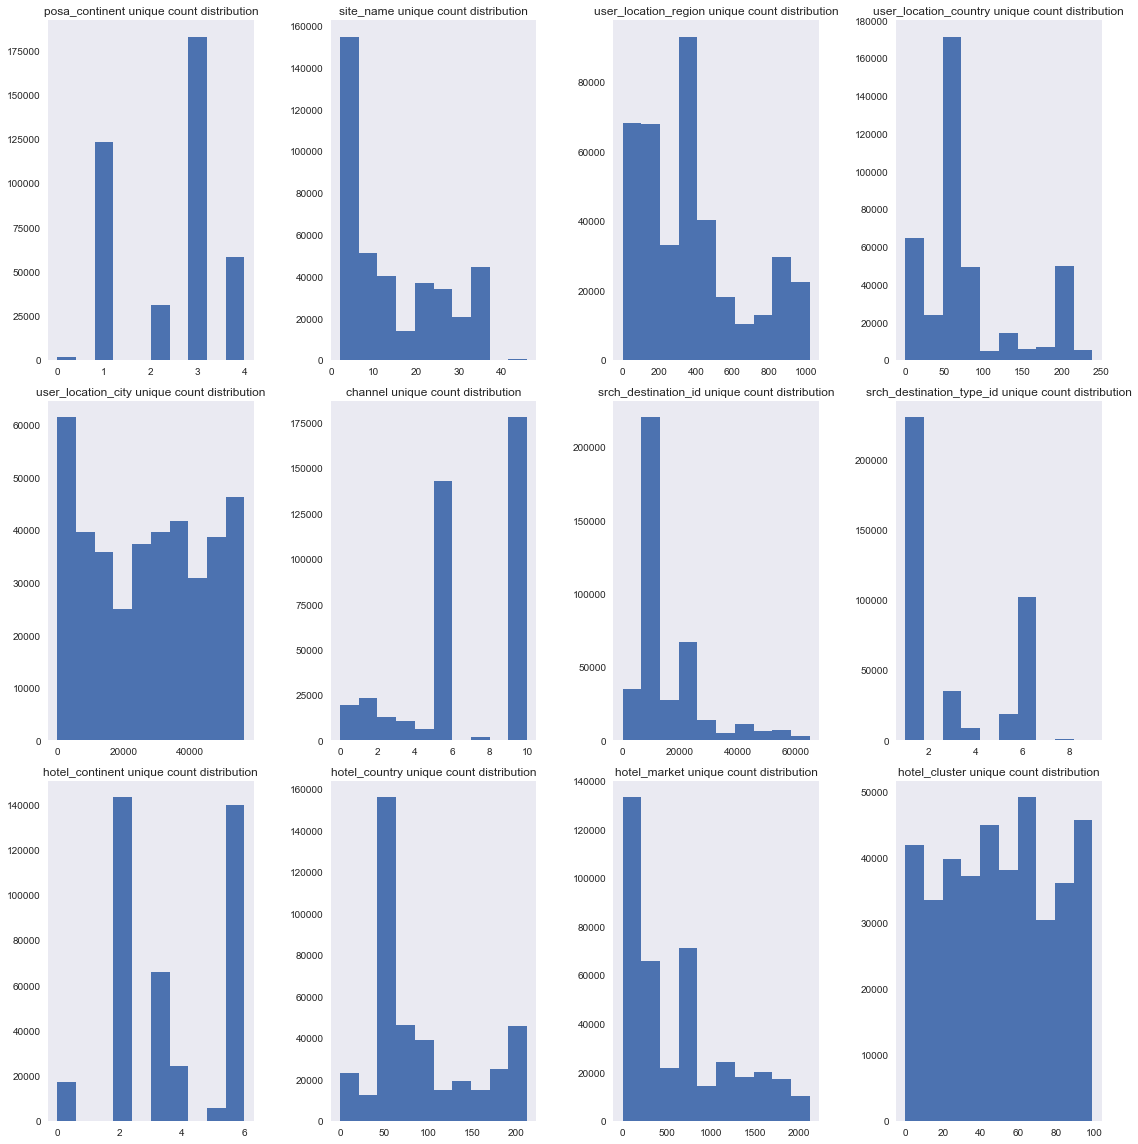

In [84]:
plot_category_freq_distribution(df_sample, ['posa_continent', 'site_name', 'user_location_region', 
                                            'user_location_country', 'user_location_city', 'channel', 
                                            'srch_destination_id', 'srch_destination_type_id',
                                            'hotel_continent', 'hotel_country', 'hotel_market',
                                            'hotel_cluster'])

As we can see, some categories describe far more instances than other categories. Most importantly, though, the final plot depicting the class distribution for our target variable, `hotel_cluster`, appears to be relatively balanced.

To account for the categories with insufficiently represented levels, we will collapse the under-represented levels whenever the sum of their frequencies is less than some threshold.

In [85]:
def fix_least_common_categorical(data, column, n_min=100):
    series = data[column]
    common_values = series.value_counts().index[series.value_counts() >= n_min]
    uncommon_values = series.value_counts().index[series.value_counts() < n_min]
    most_common_val = common_values[0]
    values = series.values
    if series[~series.isin(common_values)].value_counts().sum() >= n_min:
        values[series.isin(uncommon_values)] = 517
    else:
        values[series.isin(uncommon_values)] = most_common_val

In [86]:
N_MIN = 100

for col in categorical_variables:
    fix_least_common_categorical(data=df_sample, column=col, n_min=N_MIN)

### Feature Engineering

As datetime objects, dates are not useful. Furthermore, the data notes do not specify if the dates are localized or they all have a common time zone, this could introduce an unwanted bias effect. We are looking for seasonality and other features such as length of stay and the span from the time the booking was made to the actual stay. We also theorize that customers have different behavior if their trip is recreational or not, our proxy for this will be the variable *reservation_has_weekend* which ensures that the booking contains at least one weekend night.

In [87]:
%%time

# Convert check-in/check-out objects to datetime
df_sample['srch_ci'] = pd.to_datetime(df_sample['srch_ci'])
df_sample['srch_co'] = pd.to_datetime(df_sample['srch_co'])

# Compute number of days between day of booking and check-in date
df_sample['days_to_reservation'] = (df_sample.srch_ci - df_sample.date_time).dt.days

# Determine if reservation contains a weekend day
s = df_sample.srch_ci.dt.dayofweek
e = df_sample.srch_co.dt.dayofweek
dt = (df_sample.srch_co - df_sample.srch_ci).dt.days
df_sample['reservation_has_weekend'] = (
    ((s >= 4) & (s != 6)) | ( e >= 5) | ((e < s) & (s != 6)) | (dt >= 6) ).astype(np.int8)

# Compute length of stay, in nights
df_sample['reservation_length'] = dt

# Determine month in which midpoint of reservation occurs
df_sample['reservation_month'] = (df_sample.srch_ci + pd.to_timedelta(np.ceil(dt/2), unit='D')).dt.month

# Remove temporary variables
del s, e, dt

CPU times: user 8.37 s, sys: 76.4 ms, total: 8.45 s
Wall time: 8.51 s


With our newly created variables we can finally get rid of the original datetime objects.

In [88]:
# Drop time variables
df_sample.drop(['srch_ci', 'srch_co'], axis=1, inplace=True)

With our new variables, let's redefine the features that we will be using for modeling.

In [141]:
# Store lists for different variable types
categorical_headers = ['hotel_continent', 'hotel_country', 'hotel_market', 'reservation_month']
boolean_headers = ['is_mobile', 'is_package', 'reservation_has_weekend', 'is_booking']
count_headers = ['srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'days_to_reservation', 'reservation_length']

# Create combined list with all features
feature_columns = categorical_headers + boolean_headers + count_headers

#### Cross-Product Features

The wide and deep network blends the wide network's ability to memorize combinations of features with the deep network's ability to generalize with latent features, allowing the recommender system to provide accurate results while also serving up fresh recommendations that the user may not have explored before.

While the deep network relies mainly on the architecture and values of the hyperparameters that are selected, the wide network depends heavily on the cross-product features that are created.

We will test the performance of three different cross-product features.

**`user_location_country`-`hotel_country`**:
It could be useful to capture what kind of hotels customers purchase when traveling within their own country vs. traveling outside of their country. For instance, if customers are traveling from USA to Europe, they may be more likely to select a _leisure_ hotel than a _business_ hotel.

**`srch_destination_id`-`hotel_market`**:
This captures specific markets within destinations, providing a more granular view of a particular destination. For instance, New York City may have different hotel types between Manhattan and Queens. The cross-product here allows us to identify those differences.

**`user_id`-`srch_destination_id`**:
This allows us to capture user-level preferences. Perhaps a particular user prefers JW Marriott (or similar hotels) in Paris, but stays in a lower-tier hotel during weekly business trips to suburban Illinois. User-level cross-product features allows us to memorize these preferences.

### Cross Validation

#### Train / Test Split
Now we want to split our data into a train and holdout test set so we can measure our learning algorithm's performance later on. Typically, we would randomly split the data into 80/20 sets, for instance. However, there may be a temporal structure that we want to preserve with this data. After all, we are trying to use _previous_ user history to predict _future_ user events.

In order to determine the appropriate split point, we can visualize the number of observations that fall into different time periods.

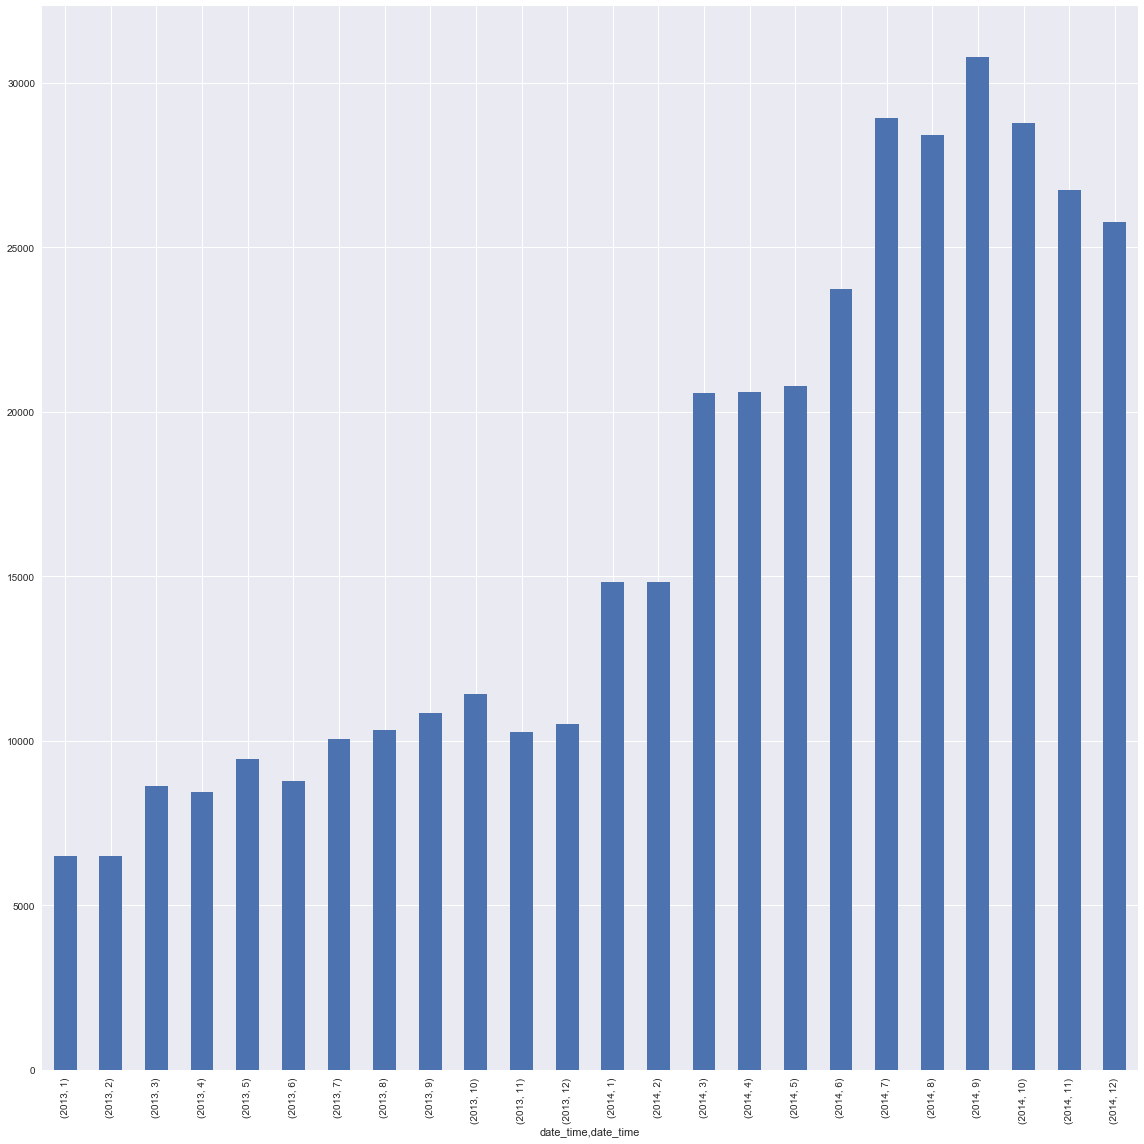

In [142]:
# Plot the distribution of observations by month, year
df_sample.groupby([df_sample.date_time.dt.year, 
                   df_sample.date_time.dt.month])['date_time'].count().plot(kind='bar')
plt.tight_layout()

We can see that most of the mass resides in the last several months, so we should save the last several months for the test set and allocate the remaining observations to the training set.

In [143]:
idx = (df_sample.date_time.dt.year == 2014) & (df_sample.date_time.dt.month >= 8)
train = df_sample[~idx]
test = df_sample[idx]

Finally, we need to remove all click events from the test set since we are trying to predict which hotel clusters users will _book_, not _click on_.

In [144]:
test = test[test.is_booking == True]

In [145]:
print("There are {} instances in the training set, {} in the test set.".format(train.shape[0], test.shape[0]))
print((train.shape[0]/df_sample.shape[0], test.shape[0]/df_sample.shape[0]))

There are 255983 instances in the training set, 10248 in the test set.
(0.6456586660209651, 0.025848239958836526)


#### Internal Cross Validation Scheme
Now that we have a training set and a test set, we want to establish an internal cross validation scheme so that we can test different architectures or other hyperparameters against our evaluation metric without overfitting to our test set.

Similar to how we separated our training and holdout set, we want to preserve both the dependency structure within user events as well as the time series nature of the problem. For this reason, we will again keep users together in each fold and separate the training and test sets according to a month cutoff. This is the algorithm:
1. Sample user IDs from the training set
2. Split the resulting DataFrame according to a specific month
3. Train the model on the training set, evaluate on validation set
4. Repeat _k_ times
5. Take mean of _k_ evaluation scores

Below we define the algorithm in a custom function that we can use later on within a loop.

In [300]:
def custom_k_fold_cv(data, K):
    # Subsample training set with N/K users, where N = # of users in train
    CV_SAMPLE_SIZE = np.floor(len(data.user_id.unique()) / K).astype(np.int)
    cv_user_sample = data.user_id.sample(CV_SAMPLE_SIZE)
    train_sample = data[data.user_id.isin(cv_user_sample)]

    # Split subsampled training set into new train/test set
    idx = (train_sample.date_time.dt.year == 2014) & (train_sample.date_time.dt.month >= 5)
    cv_train = train_sample[~idx]
    cv_test = train_sample[idx]

    # Remove 'clicks' from test set
    cv_test = cv_test[cv_test.is_booking == True]
    
    return cv_train, cv_test

### Evaluation Metric

Since our ultimate goal is to make recommendations to our users, we are mostly concerned with predicting hotel clusters that are relevant to our customers. Thus, we want to avoid false positives as much as possible, serving up only results in which customers may truly be interested. The **precision score**, which evaluates the classifier's ability to avoid classifying an instance as positive when it is actually negative, seems to be the most appropriate measure.

Furthermore, rather than serving up a single result to our customers, we would like to present several of the most relevant hotel clusters. In order to capture the precision associated with _multiple_ predictions, we can use the **Mean Average Precision** of our predictions to measure our classifier's performance.

**Mean Average Precision @ k (MAP@k)** computes the mean of the average precision scores computed for each of _k_ predictions. The score essentially weights the appearance of relevant results at the top of the page higher than relevant results returned lower in the page. For instance, if we are making five predictions and returning five results to the user (MAP@5), then correctly predicting the _most_ relevant result would yield an average precision (AP) of `1/1 = 100%`. If, instead, we returned our first relevant result in the fifth result position, then the average precision for that result would be `1/5 = 20%`. In the latter case, the MAP@5 would be the mean of the APs for all five results: `mean(0, 0, 0, 0, 0.2) = 4%`.

For our purposes, we will use the MAP@5 score to measure the mean average precision of our five predicted hotel clusters, properly accounting for the order of our predictions. Fortunately, Ben Hamner, co-founder and CTO of Kaggle, has written an implementation of the MAP@k algorithm as part of the `ml_metrics` package: `mapk`. (https://github.com/benhamner/Metrics)

Since we are comparing five predicted hotel clusters to just a single booked cluster, we can interpret MAP@5 results as follows:
* 1.00 - On average, correct cluster was predicted first in array.
* 0.50 - On average, correct cluster was predicted second in array.
* 0.33 - On average, correct cluster was predicted third in array.
* 0.25 - On average, correct cluster was predicted fourth in array.
* 0.20 - On average, correct cluster was predicted fifth in array.

In [146]:
# pip install ml_metrics
from ml_metrics import mapk

### Benchmarks
We want to create a couple of simple, heuristics-based benchmarks against which we can compare the performance of our classifier. Below we will create two benchmarks, one recommending the most common hotel clusters in the data set, and the other recommending the most _relevant_ hotel clusters for each search destination.

#### Benchmark: Most Common Clusters

We can test out the metric by creating a very basic benchmark, simply recommending the five most common hotel clusters to all of our users. Credit to Vik Paruchuri for this benchmark idea and implementation (https://www.dataquest.io/blog/kaggle-tutorial/).

In [147]:
# Store the five most common hotel clusters
most_common_clusters = list(train.hotel_cluster.value_counts().head(5).index)
most_common_clusters

[64, 5, 41, 82, 91]

In [148]:
# Both actual and predicted results must be lists for mapk metric
actual = [[cluster] for cluster in test['hotel_cluster']]
preds_common = [most_common_clusters for i in range(test.shape[0])]

In [149]:
# Compute mean average precision for predictions on test set
mapk(actual=actual, predicted=preds_common, k=5)

0.05211911267239136

#### Benchmark: Most Relevant Clusters

Another, more sophisticated benchmark can be employed that computes a hotel cluster's "relevance" based on how often it receives a click or a booking for a particular destination. Credit to Kaggle user `dune_dweller` for the idea and implementation (https://www.kaggle.com/dvasyukova/predict-hotel-type-with-pandas).

In [150]:
CLICK_WEIGHT = 0.05

# Group by destination and hotel cluster
train_grouped = train.groupby(['srch_destination_id', 
                            'hotel_cluster'])['is_booking'].agg(['sum', 'count'])

# Regroup data to subtract sum from counts
train_grouped = train_grouped.groupby(['srch_destination_id', 'hotel_cluster']).sum().reset_index()
train_grouped['count'] -= train_grouped['sum']

# Rename columns
train_grouped = train_grouped.rename(columns={'sum' : 'bookings', 'count' : 'clicks'})

# Compute relevance
train_grouped['relevance'] = train_grouped['bookings'] + CLICK_WEIGHT * train_grouped['clicks']

# Print resulting df
train_grouped.head()

,srch_destination_id,hotel_cluster,bookings,clicks,relevance
0,1,20,0,3,0.15
1,1,30,0,2,0.10
2,1,57,0,1,0.05
3,4,40,0,1,0.05
4,4,57,0,1,0.05


Determine most popular hotel cluster for a given destination based on weighted sum of clicks and bookings.

In [151]:
def find_most_relevant(group, n_max=5):
    relevance = group['relevance'].values
    hotel_cluster = group['hotel_cluster'].values
    most_relevant = hotel_cluster[np.argsort(relevance)[::-1]][:n_max]
    return list(most_relevant)

# Find most popular hotel clusters for each destination id
most_relevant = train_grouped.groupby(['srch_destination_id']).apply(find_most_relevant)
most_relevant = pd.DataFrame(most_relevant).rename(columns={0: 'hotel_cluster'})

# Print resulting df
most_relevant.head()

,hotel_cluster
srch_destination_id,
1,"[20, 30, 57]"
4,"[78, 67, 82, 81, 57]"
9,"[20, 60]"
11,"[42, 48]"
14,"[38, 20, 53, 75]"


Now let's make predictions on the test set by matching the most relevant hotel clusters to the destinations for each booking event in the test set. We will fill any NaNs, bookings for destinations that exist in the test set, but not in the training set, with the most common hotel clusters we computed in the earlier benchmark: `most_common_clusters`.

In [152]:
%%time
# Merge most relevant hotel clusters by destination id
preds_relevant = test.merge(
    most_relevant, how='left', left_on='srch_destination_id', right_index=True).iloc[:, -1]

# Fill NaNs with the most common clusters determined earlier
preds_relevant.loc[preds_relevant.isnull()] = preds_relevant.loc[preds_relevant.isnull()].apply(
    lambda x: most_common_clusters) # cannot assign a list directly, so we use apply()

CPU times: user 194 ms, sys: 231 ms, total: 426 ms
Wall time: 455 ms


In [153]:
preds_relevant.head()

5732      [64, 5, 41, 82, 91]
5738     [42, 87, 34, 91, 90]
5760     [18, 47, 17, 91, 48]
21532     [18, 19, 77, 13, 4]
21534     [91, 28, 68, 41, 9]
Name: hotel_cluster_y, dtype: object

In [154]:
# Compute mean average precision for predictions on test set
mapk(actual=actual, predicted=preds_relevant, k=5)

0.25255822274264894

## Modeling

### Building a Wide and Deep Network

In [155]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.models import Model

In [156]:
# Ensure there are no missing values
train.dropna(inplace=True)
test.dropna(inplace=True)

First, we want to scale the numeric features to make sure the optimizer can more simply find a minimum.

In [157]:
from sklearn.preprocessing import StandardScaler

# Scale numeric variables
for col in count_headers:
    train[col] = train[col].astype(np.float)
    test[col] = test[col].astype(np.float)
    
    scl = StandardScaler()
    train[col] = scl.fit_transform(train[col].values.reshape(-1, 1))
    test[col] = scl.fit_transform(test[col].values.reshape(-1, 1))

Then we will define our function that fits a wide and deep network.

In [330]:
from sklearn.preprocessing import LabelEncoder

def fit_wide_deep_network(train, test, X_train_numeric, y_train, 
                          numeric_units=2, dense_units_1=50, dense_units_2=50, 
                          dense_units_final=100, optimizer='adagrad',
                          loss='sparse_categorical_crossentropy', epochs=10, 
                          batch_size=32, verbose=1):
    
    # we need to create separate sequential models for each embedding
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_branch_outputs = []

    for cols in cross_columns:
        # encode crossed columns as ints for the embedding
        enc = LabelEncoder()

        # create crossed labels
        X_crossed_train = train[cols].apply(lambda x: '_'.join(x.astype(np.str)), axis=1)
        X_crossed_test = test[cols].apply(lambda x: '_'.join(x.astype(np.str)), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train).astype('int32')
        X_crossed_test = enc.transform(X_crossed_test).astype('int32')
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        # get the number of categories
        N = len(enc.classes_)

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32',name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1)(inputs)
        x = Flatten()(x)
        all_branch_outputs.append(x)

    # merge the branches together
    if len(all_branch_outputs) > 1:
        wide_branch = concatenate(all_branch_outputs)
    else:
        wide_branch = all_branch_outputs[0]

    # reset this input branch
    all_branch_outputs = []
    # add in the embeddings
    for col in categorical_headers:
        # encode as ints for the embedding
        X_ints_train.append( train[col].values.astype('int32') )
        X_ints_test.append( test[col].values.astype('int32') )

        # get the number of categories
        N = max(X_ints_train[-1]+1)

        # create embedding branch from the number of categories
        inputs = Input(shape=(1,),dtype='int32', name=col+'_input')
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_layer')(inputs)
        x = Flatten()(x)
        all_branch_outputs.append(x)

    # numeric features
    all_inputs.append(Input(shape=(X_train_numeric.shape[1],),sparse=False,name='numeric_data'))
    x = Dense(units=numeric_units, activation='relu')(all_inputs[-1])
    all_branch_outputs.append( x )

    # merge the branches together
    deep_branch = concatenate(all_branch_outputs)
    deep_branch = Dense(units=dense_units_1,activation='relu', name='deep_branch_1')(deep_branch)
    deep_branch = Dense(units=dense_units_2,activation='relu', name='deep_branch_2')(deep_branch)

    final_branch = concatenate([wide_branch, deep_branch])
    final_branch = Dense(units=dense_units_final,activation='softmax', name='final_branch')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)

    model.compile(optimizer=optimizer,
                  loss=loss)

    model.fit(X_ints_train + [X_train_numeric],
            y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    return model, X_ints_train, X_ints_test

### Comparing Architectures

In preparation for fitting and testing the network, we must first define the variables we want to use to build the models, including the cross-product features.

In [331]:
# Store lists for different variable types
categorical_headers = ['hotel_continent', 'hotel_country', 'hotel_market', 'reservation_month', 
                       'is_mobile', 'is_package', 'reservation_has_weekend', 'is_booking']

numeric_headers = ['srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'days_to_reservation', 
                   'reservation_length']

Finally, we can use the custom k-fold CV function we defined earlier to:
* Create _K_ new train and validation sets from the _training data_ only
* Fit the wide and deep network on the new training sets
* Measure the model's performance against the validation set

This will allow us to tune our hyperparameters and test different model architectures, all without exposing the training data to the holdout test set. Once we determine the optimal architecture and hyperparameter values, we can build a complete wide and deep network using all of the training data and evaluate it against the holdout test set for a final measure of performance.

#### Architecture 1
This is the base architecture. We will compare three additional architectures with slight adjustments to model hyperparameters and cross-product features.

In [1]:
# Cross columns to memorize
cross_columns = [['user_location_country', 'hotel_country'], 
                 ['srch_destination_id', 'hotel_market']]

# Parameters to pass to wide and deep network
params = {'numeric_units' : 2, 'dense_units_1' : 50, 'dense_units_2' : 50, 
          'dense_units_final' : 100, 'optimizer' : 'adagrad',
          'loss' : 'sparse_categorical_crossentropy', 'epochs' : 10}

# Perform internal k-fold cross validation on the training set only
K = 4
maps = []
for i in range(K):
    print("Fold ", i+1, "of", K)
    print('-------------')
    
    # Create subsampled train and test set using function defined earlier
    cv_train, cv_test = custom_k_fold_cv(train, K)
    
    # Separate numeric features and class labels
    X_train_numeric = cv_train[numeric_headers].values.astype(np.float32)
    X_test_numeric = cv_test[numeric_headers].values.astype(np.float32)
    y_train = cv_train['hotel_cluster'].values.astype(np.int)
    y_test = cv_test['hotel_cluster'].values.astype(np.int)

    # Fit the wide and deep network
    model, X_ints_train, X_ints_test = fit_wide_deep_network(cv_train, cv_test, X_train_numeric, y_train, 
                                                             **params)
    
    # Make predictions on test set
    preds = np.argsort(model.predict(X_ints_test + [X_test_numeric]), axis=1)[:,-5:]
    
    # Evaluate MAP@5 metric and append to maps
    maps.append( mapk(actual=y_test.reshape(-1,1).tolist(), predicted=preds.tolist(), k=5) )
    print('')
    
print("Cross-product features:\n", cross_columns)
print('')
print("Network Architecture:\n", params)
print('')
print("The mean average precision is", np.mean(maps).round(4), '+-', np.std(maps).round(4), end='.')

NameError: name 'OneHotEncoder' is not defined

#### Architecture 2
(Best Performance)
This architecture uses the same cross-product features, but adjusts the hyperparameters for the wide and deep network, specifically adding more hidden units to the two dense hidden layers and changing the optimizer to `rmsprop`.

In [345]:
# Cross columns to memorize
cross_columns = [['user_location_country', 'hotel_country'], 
                 ['srch_destination_id', 'hotel_market']]

# Parameters to pass to wide and deep network
params = {'numeric_units' : 2, 'dense_units_1' : 200, 'dense_units_2' : 100, 
          'dense_units_final' : 100, 'optimizer' : 'rmsprop',
          'loss' : 'sparse_categorical_crossentropy', 'epochs' : 10, 'verbose' : 1}

# Perform internal k-fold cross validation on the training set only
K = 4
maps = []
for i in range(K):
    print("Fold ", i+1, "of", K)
    print('-------------')
    
    # Create subsampled train and test set using function defined earlier
    cv_train, cv_test = custom_k_fold_cv(train, K)
    
    # Separate numeric features and class labels
    X_train_numeric = cv_train[numeric_headers].values.astype(np.float32)
    X_test_numeric = cv_test[numeric_headers].values.astype(np.float32)
    y_train = cv_train['hotel_cluster'].values.astype(np.int)
    y_test = cv_test['hotel_cluster'].values.astype(np.int)

    # Fit the wide and deep network
    model, X_ints_train, X_ints_test = fit_wide_deep_network(cv_train, cv_test, X_train_numeric, y_train, 
                                                             **params)
    
    # Make predictions on test set
    preds = np.argsort(model.predict(X_ints_test + [X_test_numeric]), axis=1)[:,-5:]
    
    # Evaluate MAP@5 metric and append to maps
    maps.append( mapk(actual=y_test.reshape(-1,1).tolist(), predicted=preds.tolist(), k=5) )
    print('')
    
print("Cross-product features:\n", cross_columns)
print('')
print("Network Architecture:\n", params)
print('')
print("The mean average precision is", np.mean(maps).round(4), '+-', np.std(maps).round(4), end='.')

Fold  1 of 4
-------------
Epoch 1/10
48627/48627 [==============================] - 11s - loss: 3.7145    
Epoch 2/10
48627/48627 [==============================] - 10s - loss: 3.2529    
Epoch 3/10
48627/48627 [==============================] - 11s - loss: 3.0474    
Epoch 4/10
48627/48627 [==============================] - 10s - loss: 2.9062    
Epoch 5/10
48627/48627 [==============================] - 11s - loss: 2.7983    
Epoch 6/10
48627/48627 [==============================] - 11s - loss: 2.7211    
Epoch 7/10
48627/48627 [==============================] - 13s - loss: 2.6680    
Epoch 8/10
48627/48627 [==============================] - 12s - loss: 2.6231    
Epoch 9/10
48627/48627 [==============================] - 10s - loss: 2.5879    
Epoch 10/10
48627/48627 [==============================] - 10s - loss: 2.5567    

Fold  2 of 4
-------------
Epoch 1/10
44659/44659 [==============================] - 10s - loss: 3.7559    
Epoch 2/10
44659/44659 [=============================

#### Architecture 3
This architecture retains the hyperparameters from Architecture 2, but adjusts the cross-product features used.

In [347]:
# Cross columns to memorize
cross_columns = [['user_location_country', 'hotel_country'], 
                 ['user_id', 'srch_destination_type_id']]

# Parameters to pass to wide and deep network
params = {'numeric_units' : 2, 'dense_units_1' : 200, 'dense_units_2' : 100, 
          'dense_units_final' : 100, 'optimizer' : 'rmsprop',
          'loss' : 'sparse_categorical_crossentropy', 'epochs' : 10}

# Perform internal k-fold cross validation on the training set only
K = 4
maps = []
for i in range(K):
    print("Fold ", i+1, "of", K)
    print('-------------')
    
    # Create subsampled train and test set using function defined earlier
    cv_train, cv_test = custom_k_fold_cv(train, K)
    
    # Separate numeric features and class labels
    X_train_numeric = cv_train[numeric_headers].values.astype(np.float32)
    X_test_numeric = cv_test[numeric_headers].values.astype(np.float32)
    y_train = cv_train['hotel_cluster'].values.astype(np.int)
    y_test = cv_test['hotel_cluster'].values.astype(np.int)

    # Fit the wide and deep network
    model, X_ints_train, X_ints_test = fit_wide_deep_network(cv_train, cv_test, X_train_numeric, y_train, 
                                                             **params)
    
    # Make predictions on test set
    preds = np.argsort(model.predict(X_ints_test + [X_test_numeric]), axis=1)[:,-5:]
    
    # Evaluate MAP@5 metric and append to maps
    maps.append( mapk(actual=y_test.reshape(-1,1).tolist(), predicted=preds.tolist(), k=5) )
    print('')
    
print("Cross-product features:\n", cross_columns)
print('')
print("Network Architecture:\n", params)
print('')
print("The mean average precision is", np.mean(maps).round(4), '+-', np.std(maps).round(4), end='.')

Fold  1 of 4
-------------
Epoch 1/10
44658/44658 [==============================] - 10s - loss: 3.7640    
Epoch 2/10
44658/44658 [==============================] - 9s - loss: 3.3038     
Epoch 3/10
44658/44658 [==============================] - 9s - loss: 3.1145     
Epoch 4/10
44658/44658 [==============================] - 9s - loss: 2.9926     
Epoch 5/10
44658/44658 [==============================] - 9s - loss: 2.9051     
Epoch 6/10
44658/44658 [==============================] - 9s - loss: 2.8376     
Epoch 7/10
44658/44658 [==============================] - 9s - loss: 2.7824     
Epoch 8/10
44658/44658 [==============================] - 9s - loss: 2.7379     
Epoch 9/10
44658/44658 [==============================] - 9s - loss: 2.7022     
Epoch 10/10
44658/44658 [==============================] - 9s - loss: 2.6741     
Fold  2 of 4
-------------
Epoch 1/10
47353/47353 [==============================] - 11s - loss: 3.7425    
Epoch 2/10
47353/47353 [==============================

#### Architecture 4
This architecture changes the cross-product features to capture user level characteristics. It performs similarly to Architecture 3, but does not compete with Architecture 2.

In [348]:
# Cross columns to memorize
cross_columns = [['user_id', 'srch_destination_id'], 
                 ['srch_destination_id', 'hotel_market'], 
                 ['user_id', 'hotel_market']]

# Parameters to pass to wide and deep network
params = {'numeric_units' : 2, 'dense_units_1' : 200, 'dense_units_2' : 100, 
          'dense_units_final' : 100, 'optimizer' : 'rmsprop',
          'loss' : 'sparse_categorical_crossentropy', 'epochs' : 10}

# Perform internal k-fold cross validation on the training set only
K = 4
maps = []
for i in range(K):
    print("Fold ", i+1, "of", K)
    print('-------------')
    
    # Create subsampled train and test set using function defined earlier
    cv_train, cv_test = custom_k_fold_cv(train, K)
    
    # Separate numeric features and class labels
    X_train_numeric = cv_train[numeric_headers].values.astype(np.float32)
    X_test_numeric = cv_test[numeric_headers].values.astype(np.float32)
    y_train = cv_train['hotel_cluster'].values.astype(np.int)
    y_test = cv_test['hotel_cluster'].values.astype(np.int)

    # Fit the wide and deep network
    model, X_ints_train, X_ints_test = fit_wide_deep_network(cv_train, cv_test, X_train_numeric, y_train, 
                                                             **params)
    
    # Make predictions on test set
    preds = np.argsort(model.predict(X_ints_test + [X_test_numeric]), axis=1)[:,-5:]
    
    # Evaluate MAP@5 metric and append to maps
    maps.append( mapk(actual=y_test.reshape(-1,1).tolist(), predicted=preds.tolist(), k=5) )
    print('')
    
print("Cross-product features:\n", cross_columns)
print('')
print("Network Architecture:\n", params)
print('')
print("The mean average precision is", np.mean(maps).round(4), '+-', np.std(maps).round(4), end='.')

Fold  1 of 4
-------------
Epoch 1/10
47160/47160 [==============================] - 22s - loss: 3.7117    
Epoch 2/10
47160/47160 [==============================] - 21s - loss: 3.0641    
Epoch 3/10
47160/47160 [==============================] - 20s - loss: 2.6909    
Epoch 4/10
47160/47160 [==============================] - 19s - loss: 2.4603    
Epoch 5/10
47160/47160 [==============================] - 21s - loss: 2.3077    
Epoch 6/10
47160/47160 [==============================] - 21s - loss: 2.2021    
Epoch 7/10
47160/47160 [==============================] - 19s - loss: 2.1246    
Epoch 8/10
47160/47160 [==============================] - 20s - loss: 2.0688    
Epoch 9/10
47160/47160 [==============================] - 19s - loss: 2.0330    
Epoch 10/10
47160/47160 [==============================] - 23s - loss: 1.9940    

Fold  2 of 4
-------------
Epoch 1/10
45635/45635 [==============================] - 22s - loss: 3.6579    
Epoch 2/10
45635/45635 [=============================

### Comparing Wide and Deep Network to MLP

We will select the architecture that produced the highest mean average precision from our four candidates above. For the first time, we will train the model on the full training set and evaluate its performance against the holdout test set. This should provide us with the most accurate mean average precision.

We will then compare the wide and deep network's performance against that of an out-of-the-box multi-layer perceptron.

In [349]:
# Cross columns to memorize
cross_columns = [['user_location_country', 'hotel_country'], 
                 ['srch_destination_id', 'hotel_market']]

# Parameters to pass to wide and deep network
params = {'numeric_units' : 2, 'dense_units_1' : 200, 'dense_units_2' : 100, 
          'dense_units_final' : 100, 'optimizer' : 'rmsprop',
          'loss' : 'sparse_categorical_crossentropy', 'epochs' : 10}

# Separate numeric features and class labels
X_train_numeric = train[numeric_headers].values.astype(np.float32)
X_test_numeric = test[numeric_headers].values.astype(np.float32)
y_train = train['hotel_cluster'].values.astype(np.int)
y_test = test['hotel_cluster'].values.astype(np.int)

# Fit the wide and deep network
best_model, X_ints_train, X_ints_test = fit_wide_deep_network(train, test, X_train_numeric, y_train, 
                                                         **params)

# Make predictions on test set
best_preds = np.argsort(best_model.predict(X_ints_test + [X_test_numeric]), axis=1)[:,-5:]

# Best MAP
best_map = mapk(actual=y_test.reshape(-1,1).tolist(), predicted=best_preds.tolist(), k=5)

Epoch 1/10
255805/255805 [==============================] - 99s - loss: 3.4541    
Epoch 2/10
255805/255805 [==============================] - 92s - loss: 3.1977    
Epoch 3/10
255805/255805 [==============================] - 90s - loss: 3.1182    
Epoch 4/10
255805/255805 [==============================] - 93s - loss: 3.0597    
Epoch 5/10
255805/255805 [==============================] - 114s - loss: 3.0586   
Epoch 6/10
255805/255805 [==============================] - 90s - loss: 3.0685    
Epoch 7/10
255805/255805 [==============================] - 90s - loss: 3.0642    
Epoch 8/10
255805/255805 [==============================] - 103s - loss: 3.0680   
Epoch 9/10
255805/255805 [==============================] - 100s - loss: 3.0676   
Epoch 10/10
255805/255805 [==============================] - 89s - loss: 3.0754    


In [351]:
best_map

0.15983443924017696

Now we will compare the wide and deep network's performance to that of a standard multi-layer perceptron. We will evaluate the performance with two different metrics:
- Mean Average Precision: The evaluation metric we defined previously.
- Area Under the Curve for the Receiver Operating Characteristic: Since the data has been anonymized, we will use a macro-average to give equal weight to all classes.

First, we must prepare the data for our MLP by one hot encoding all of the categorical variables.

In [352]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
stack = np.vstack((train[categorical_headers].values, test[categorical_headers].values))
enc.fit(stack)

X_train_cat = enc.transform(train[categorical_headers]).A.astype(np.float32)
X_test_cat = enc.transform(test[categorical_headers]).A.astype(np.float32)

X_train_bool =  train[boolean_headers].values.astype(np.float32)
X_test_bool = test[boolean_headers].values.astype(np.float32)

X_train_count =  train[count_headers].values.astype(np.float32)
X_test_count = test[count_headers].values.astype(np.float32)

X_train = np.hstack((X_train_cat, X_train_bool, X_train_count))
X_test = np.hstack((X_test_cat, X_test_bool, X_test_count))

y_train = train['hotel_cluster'].values.astype(np.float32)
y_test = test['hotel_cluster'].values.astype(np.float32)

Next, we will define the architecture: a two-layer MLP with dropout to ensure regularization.

In [353]:
from keras.layers.core import Dense, Activation, Dropout

input_dim = X_train.shape[1]
nb_classes = 100

mlp_model = Sequential()
mlp_model.add(Dense(200, input_dim=input_dim))
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(100, input_dim=200))
mlp_model.add(Activation('relu'))
mlp_model.add(Dropout(0.5))
mlp_model.add(Dense(nb_classes, input_dim=100))
mlp_model.add(Activation('softmax'))

mlp_model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

Now we can train the MLP and score it on the test data.

In [354]:
mlp_model.fit(X_train, y_train, epochs=10)

mlp_preds = np.argsort(mlp_model.predict(X_test), axis=1)[:,-5:]

# MLP MAP
mlp_map = mapk(actual=y_test.reshape(-1,1).tolist(), predicted=mlp_preds.tolist(), k=5)

Epoch 1/10
255805/255805 [==============================] - 47s - loss: 3.8515    
Epoch 2/10
255805/255805 [==============================] - 40s - loss: 3.8203    
Epoch 3/10
255805/255805 [==============================] - 42s - loss: 3.8782    
Epoch 4/10
255805/255805 [==============================] - 43s - loss: 3.9229    
Epoch 5/10
255805/255805 [==============================] - 40s - loss: 3.9550    
Epoch 6/10
255805/255805 [==============================] - 39s - loss: 3.9835    
Epoch 7/10
255805/255805 [==============================] - 41s - loss: 4.0097    
Epoch 8/10
255805/255805 [==============================] - 41s - loss: 4.0298    
Epoch 9/10
255805/255805 [==============================] - 40s - loss: 4.0565    
Epoch 10/10
255805/255805 [==============================] - 40s - loss: 4.0787    


In [355]:
mlp_map

0.12261742128545407

If we compare the Mean Average Precision for both methods, we can see that the wide and deep network has a considerably higher mean average precision.

The next metric will help us determine the area under the Receiver Operating Characteristic curve (AUC of ROC), which provides insight into the trade-off between a model's specificity and sensitivity.

In [83]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def roc_auc_analysis(test, score, plot=False, plot_n = 5):
    n_classes = score.shape[1]
    y_score = score
    y_test = label_binarize(test, classes=np.arange(100))

    lw = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    if (plot):
        cmap = cm.gist_ncar
        norm = Normalize(vmin=0, vmax=n_classes)

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i in range(plot_n):
            color = cmap(norm(i))
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()
    return(roc_auc)

Let's plot the AUC curve for the first 5 levels of the response variable for the best model:

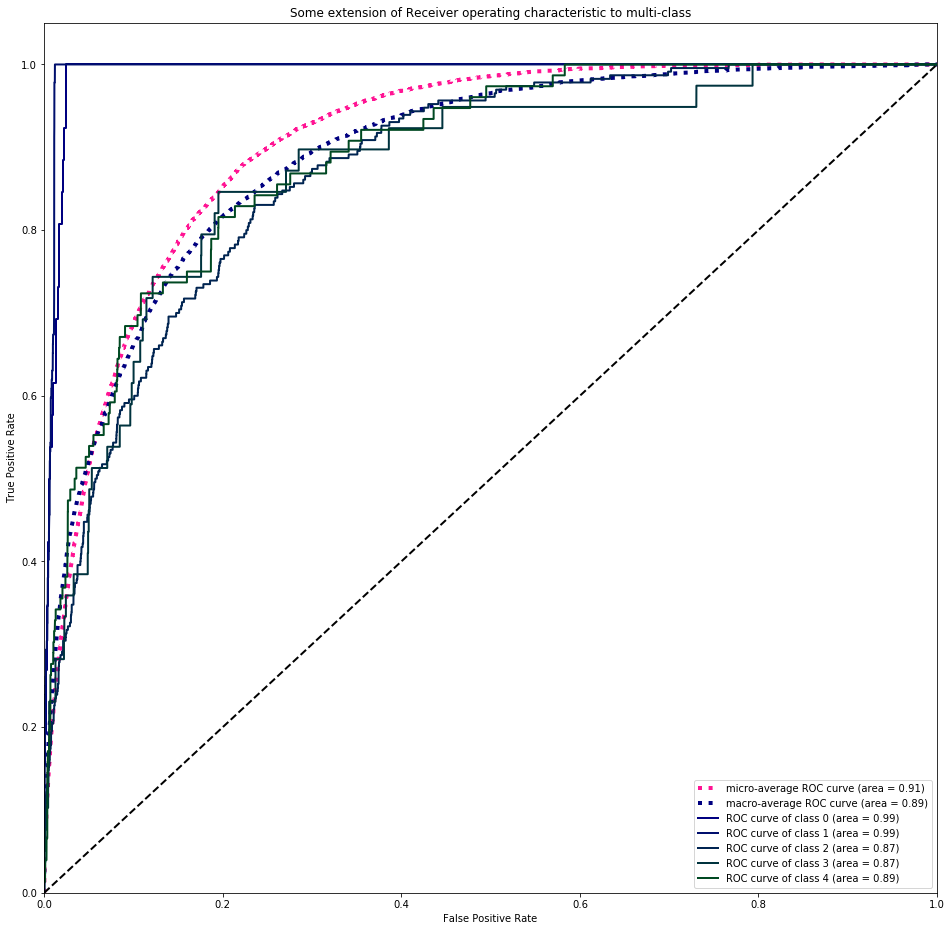

The macro AUC is: 0.891010111355


In [89]:
best_auc = roc_auc_analysis(y_test, best_model.predict(X_ints_test + [X_test_numeric]), plot=True)
print('The macro AUC is: %s'%(best_auc['macro']))

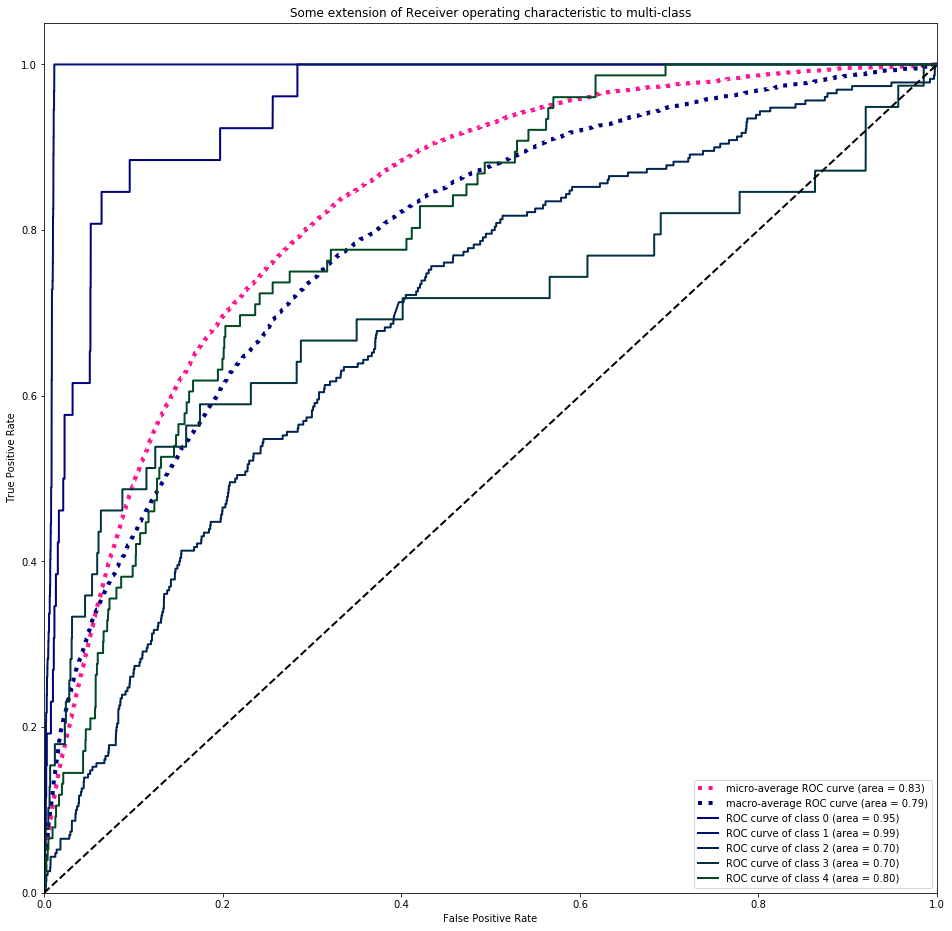

The macro AUC is: 0.789643943338


In [90]:
mlp_auc = roc_auc_analysis(y_test, mlp_model.predict(X_test), plot=True)
print('The macro AUC is: %s'%(mlp_auc['macro']))

As we can see from the previous graphs, the macro-average ROC AUC is considerably larger for our wide and deep network compared with the MLP. In fact, the network has superior results on the individual classes displayed as well as the micro and macro averages.

The two metrics analyzed support our observation that the wide and deep network yields superior results to MLP. The downside of this architecture is the increased training time and the number of weights that need to be saved and optimized. For our purpose, however, the wide and deep network will work just fine as we are likely to implement it on a powerful server. 

### Visualizing Embedding Weights

The embeddings are representations of categorical variables in a lower dimension that a neural network can use effectively as the weights have been optimized. With this in mind, it is possible to understand which levels of a category are important for predictions by finding out those levels that have the largest positive weights as inputs to the embedding neuron.

In [91]:
def plot_weights(model, header):
    weights = model.get_layer(header).get_weights()
    
    def autolabel(rects, label):
        for rect in rects:
            height = 0
            ax.text(rect.get_x() + rect.get_width()/2., height, '%d'%int(label), ha='center', va='bottom')

    #VARIABLES    
    N_levels = weights[0].shape[0]
    N_embeddings = weights[0].shape[1]
    width = .8/N_levels
    
    #COLOR
    cmap = cm.gist_ncar
    norm = Normalize(vmin=0, vmax=N_levels)
    
    #PLOT
    fig, ax = plt.subplots()
    for l in np.arange(N_levels):    
        plot_weights = weights[0][l,:]
        color = cmap(norm(l))
        rect = ax.bar(np.arange(N_embeddings)+width*l, plot_weights, width, color=color)    
        autolabel(rect, l)
        
    plt.title(header)

We will plot the weights that serve as inputs for the hotel_continent. That is, we will set out to find which continents are most important when predicting a hotel category. To do this, we look at how each level of the category contributes to the activation of the neurons and pick those that have the highest positive values.

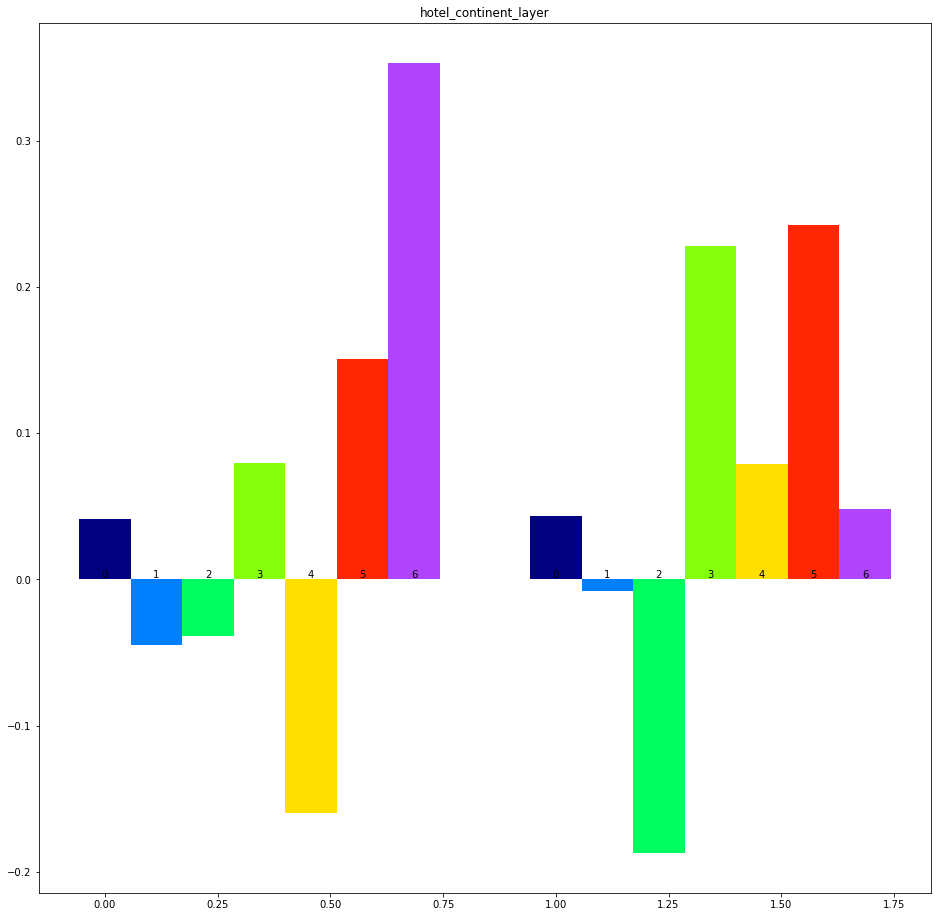

In [93]:
plot_weights(best_model, categorical_headers[0]+'_layer')

On the previous example, the embedding on the left is composed mainly of the continent encoded as 6 followed by 5. Continents 1, 2, and 4 do not contribute anything to the activation of the neuron; therefore, these may not be important for predictions derived from that embedding. The embedding on the right is composed of contributions from continents 3 and 5, with minor contributions from 0, 4, and 6. The same reasoning applies. Both embeddings have important contributions from continent 5, which is good evidence to support the notion that continent 5 is crucial to making predictions.

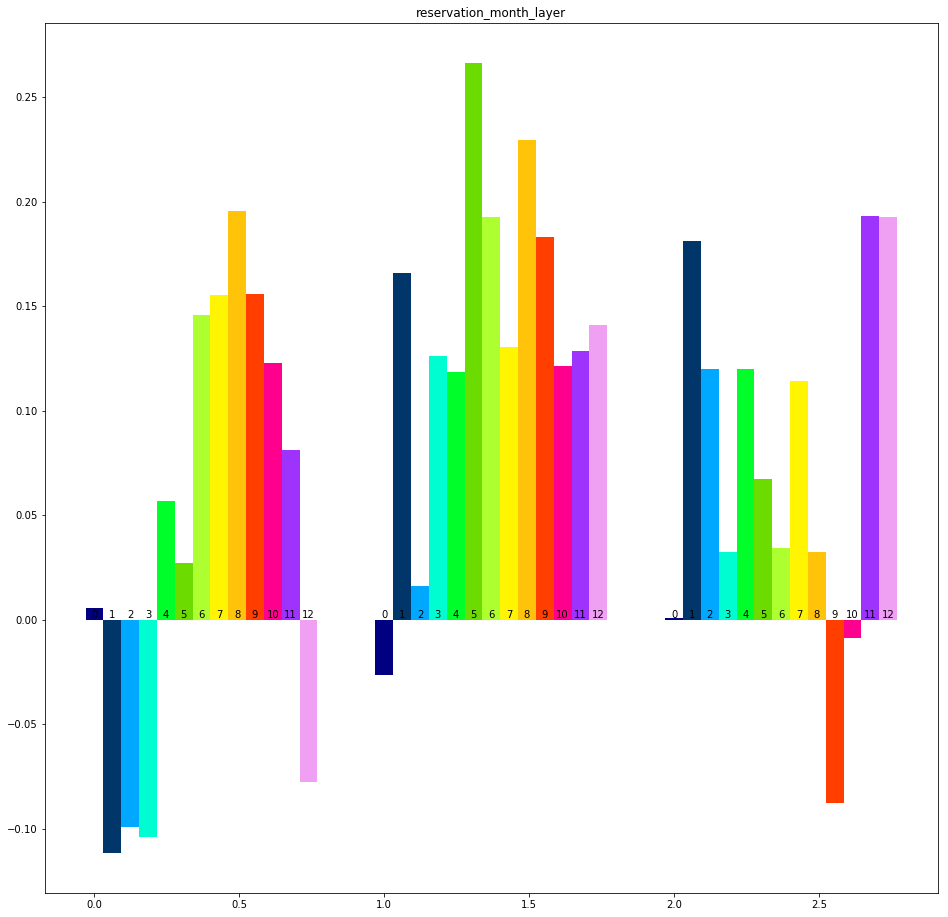

In [94]:
plot_weights(model, categorical_headers[3]+'_layer')

Above we analyze the weights for the embeddings related to the reservation month:
- The embedding on the left is composed of summer-autumn months. It may be that this neuron captures summer reservations.
- The embedding to the right might represent the effect of reservations made during Christmas-New Years.
- The embedding in the middle is more difficult to understand and would likely need more investigation.

## Conclusion

While the wide and deep network outperformed the multilayer perceptron, it did not outperform the benchmark recommender that simply recommended the most often clicked and booked hotel cluster for each specific destination. The classifier's inability to surpass the benchmark could likely be mitigated by reevaluating the architecture and the features used to build the network, as well as by training the network with the full amount of data (if we did not have the memory or computation time constraints).

Regardless, the mean average precision score of ~0.16 indicates that the correct hotel type was among the top 5 results _almost_ every time (a MAP@5 score of 0.20 indicates that the correct cluster is the 5th place result on average). While not ideal, this performance provides a baseline from which we can further improve.